<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/Human_Emotion_Classification(Comeback_and_Train_for_better_results).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf
import tensorflow.keras as keras
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization

#### Load the images

In [14]:
path = "/content/drive/MyDrive/Computer Vision Masterclass Files/Datasets/fer_images.zip"

zip_object= zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall("./")
zip_object.close()

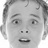

In [15]:
image = keras.preprocessing.image.load_img("/content/fer2013/train/Fear/1001.jpg")

image

### Train and Test Split

In [16]:
train_gen = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range = 7,
    horizontal_flip = True,
    zoom_range = 0.2
)

train_dataset= train_gen.flow_from_directory(
    "/content/fer2013/train",
    target_size = (48, 48),
    batch_size = 16,
    class_mode = "categorical",
    shuffle = True
)

train_dataset.class_indices

Found 28709 images belonging to 7 classes.


{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [17]:
# returns classes in dataset along with their occurence in dataset
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

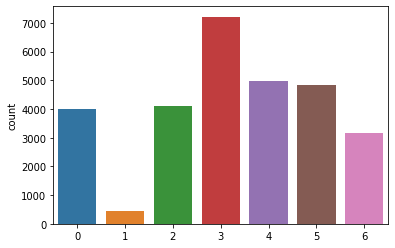

In [18]:
sns.countplot(x = train_dataset.classes);

In [19]:
test_gen = ImageDataGenerator(rescale = 1/255.)

test_dataset = test_gen.flow_from_directory("/content/fer2013/validation",
                                            target_size = (48, 48),
                                            batch_size = 1,
                                            class_mode = "categorical",
                                            shuffle = False)

Found 3589 images belonging to 7 classes.


### Build and Train Model

In [20]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

num_detectors = 32
num_classes = 7
width, height = 48, 48
epochs = 80


# Arc of littleVGG
model = Sequential()

model.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
model.add(BatchNormalization())  # normalizes values gotten as input.
model.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(2 * num_detectors, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(2 * num_detectors, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_11 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                      

In [21]:
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [22]:
# history= model.fit(train_dataset, validation_data=test_dataset, epochs = epochs)

#### Loads the Already Trained Model weights for clf tasks(since I previously reached my Colab GPU limit)

In [23]:
model.load_weights("/content/drive/MyDrive/Computer Vision Masterclass Files/Weights/weights_emotions.hdf5")
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

#### Eval Model

In [24]:
model.evaluate(test_dataset)   # statet of art results for these tasks is 80% so this is our benchmark

3589/3589 [==============================] - 16s 4ms/step - loss: 1.5148 - accuracy: 0.5779


[1.5148497819900513, 0.5778768658638]

In [25]:
predictions = np.argmax(model.predict(test_dataset), axis = 1)

y_test = test_dataset.classes

Model accuracy: 0.5778768459180831
Model precision: 0.5551577589137313
Model recall: 0.5778768459180831
Model f1_score: 0.5644634996030952


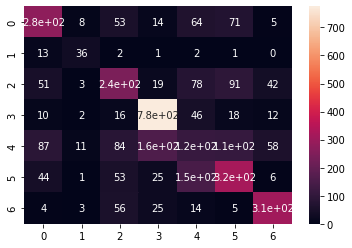

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
confusion_matrix, classification_report


print(f"Model accuracy: {accuracy_score(y_test, predictions)}")
print(f"Model precision: {precision_score(y_test,predictions, average = 'weighted')}")
print(f"Model recall: {recall_score(y_test, predictions, average = 'weighted')}")
print(f"Model f1_score: {f1_score(y_test, predictions, average = 'weighted')}")


sns.heatmap(confusion_matrix(y_test, predictions), annot =True)

In [27]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       491
           1       0.56      0.65      0.61        55
           2       0.48      0.46      0.47       528
           3       0.76      0.88      0.82       879
           4       0.25      0.18      0.21       626
           5       0.52      0.54      0.53       594
           6       0.72      0.74      0.73       416

    accuracy                           0.58      3589
   macro avg       0.55      0.57      0.56      3589
weighted avg       0.56      0.58      0.56      3589



#### Classify a single image

In [28]:
image = cv2.imread("/content/drive/MyDrive/Computer Vision Masterclass Files/Images/gabriel.png")

image.shape

(300, 400, 3)

In [29]:
# detect the face before getting his emotion
face_detector = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

original_image = image.copy()

# to store faces detected
faces = face_detector.detectMultiScale(original_image)

print(len(faces))

faces

1


array([[162,  40, 128, 128]], dtype=int32)

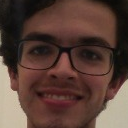

In [30]:
# extract just then face region from the image
roi = image[40:40 + 128, 162:162 + 128]

cv2_imshow(roi)

In [31]:
roi.shape

(128, 128, 3)

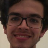

In [32]:
roi = cv2.resize(roi, (48, 48))

cv2_imshow(roi)

In [33]:
roi = roi / 255.0 # normalize
roi.shape

(48, 48, 3)

In [34]:
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48, 3)

In [35]:
image_pred = np.argmax(model.predict(roi), axis = 1)

image_pred  # prediction is class 3 which is "Happy"

array([3])

### Clf Multiple Images

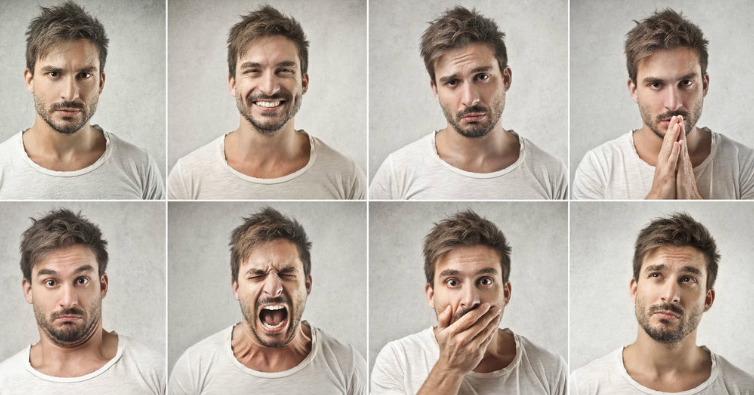

In [36]:
# image having multipe faces
image = cv2.imread("/content/drive/MyDrive/Computer Vision Masterclass Files/Images/faces_emotions.png")  
cv2_imshow(image)

In [37]:
faces = face_detector.detectMultiScale(image)

faces

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

In [38]:
emotions = [t for t in test_dataset.class_indices.keys()]
emotions

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

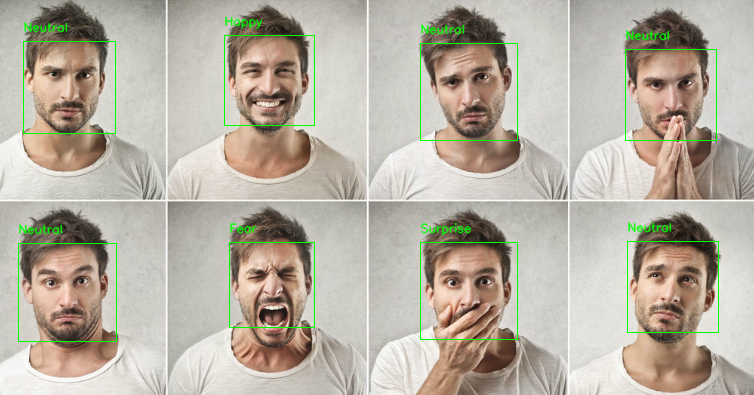

In [39]:
for (i, (x1, y1, x2, y2)) in enumerate(faces):
  cv2.rectangle(image, (x1, y1), (x1 + x2, y1 + y2), (0, 255, 0), 1)
  roi = image[y1:y1 + y2, x1:x1 + x2]

  # if(i < 2):
  #   cv2_imshow(roi)

  roi = cv2.resize(roi, (48, 48))
  roi = roi / 255.
  roi = np.expand_dims(roi, axis = 0)
  emotion_pred = np.argmax(model.predict(roi), axis = 1)[0]

  prediction = emotions[emotion_pred]
  cv2.putText(image, prediction, (x1, y1 -10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv2.LINE_AA)

cv2_imshow(image)

### Classify emotions in videos

In [40]:
cap = cv2.VideoCapture("/content/drive/MyDrive/Computer Vision Masterclass Files/Videos/emotion_test04.mp4")

isconnected, video = cap.read()

print(isconnected, video.shape)

True (360, 640, 3)


In [41]:
save_path = "/content/drive/MyDrive/emotion_detection_results/emotion_test04.avi"

# codec used to save the video
# fourcc.org
fourcc = cv2.VideoWriter_fourcc(*"XVID")

# less fps the slower the speed of the saved video
fps = 20
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0]))

In [42]:
while (cv2.waitKey(1) < 0):
  connected, frame = cap.read()  # read next frame
  if not connected:
    break

  faces = face_detector.detectMultiScale(frame, scaleFactor = 1.2, minNeighbors = 5, minSize = (30, 30))
  if len(faces) > 0:
    for(x1, y1, x2, y2) in faces:
    
      cv2.rectangle(frame, (x1, y1), (x1 + x2, y1 + y2), (0, 255, 0), 2)
      roi = frame[y1:y1 + y2, x1:x1 + x2]

      roi = cv2.resize(roi, (48, 48))
      roi = roi / 255.
      roi = np.expand_dims(roi, axis = 0)

      if(model.predict is not None):
        emotion_pred = np.argmax(model.predict(roi), axis = 1)[0]
        prediction = emotions[emotion_pred]
        cv2.putText(frame, prediction, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv2.LINE_AA)

  # cv2_imshow(frame)
  output_video.write(frame)  # saves video to location specified previosuly

print("End")
output_video.release()
cv2.destroyAllWindows()

End
